In [5]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv, find_dotenv
import requests
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

For this analysis I use CPI data taken from the Federal Reserve Bank API. Reproduction of this analysis requires replacing the '{key}' variable with your own API key. Official documentation for the API can be found here: https://fred.stlouisfed.org/docs/api/fred/.

In [6]:
#load env variable and cpi data
load_dotenv(find_dotenv())
key = os.getenv('fred_key')
series_id = 'CPIAUCSL'
fred_api_url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={key}&file_type=json'
response = requests.get(fred_api_url)
data = response.json()

In [28]:
#convert to pd
observations = data['observations']
df = pd.DataFrame(observations)

In [29]:
#view df
df

,realtime_start,realtime_end,date,value
0,2024-07-25,2024-07-25,1947-01-01,21.48
1,2024-07-25,2024-07-25,1947-02-01,21.62
2,2024-07-25,2024-07-25,1947-03-01,22.0
3,2024-07-25,2024-07-25,1947-04-01,22.0
4,2024-07-25,2024-07-25,1947-05-01,21.95
...,...,...,...,...
925,2024-07-25,2024-07-25,2024-02-01,311.054
926,2024-07-25,2024-07-25,2024-03-01,312.230
927,2024-07-25,2024-07-25,2024-04-01,313.207
928,2024-07-25,2024-07-25,2024-05-01,313.225


In [31]:
#change columns types
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df['value'] = pd.to_numeric(df['value'])

Looking at the line chart below, we can see that there is an obvious trend upward. This trend violates the assumption of consistency in means for any two given resonable time periods meaning the data is not stationary. There also appears to be differences in consistency of the variance which violates the assumption of consistency of variance. 

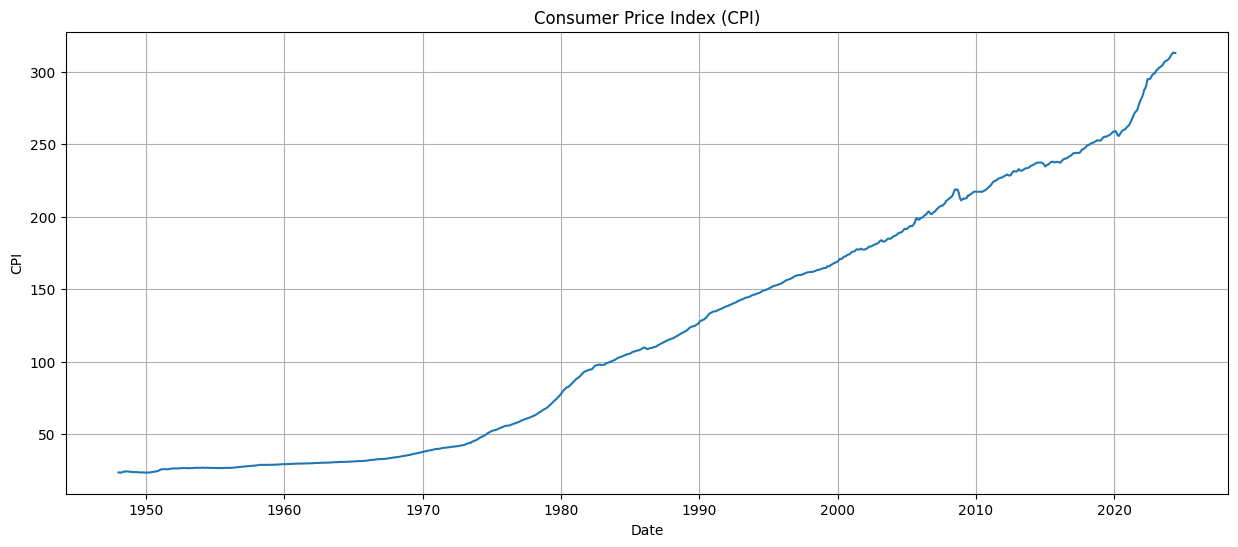

In [131]:
#line graph
plt.figure(figsize=(15, 6))
plt.plot(df['value'])
plt.title('Consumer Price Index (CPI)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

To control for the violation of consistency of means, I use a differencing approach and visualize the results using a line graph.

In [35]:
#first-order differencing for stationarity
df['value_diff'] = df['value'].diff().dropna()

df.head()

#delete first year
df = df.iloc[12:]

In [40]:
df.head()

,realtime_start,realtime_end,value,value_diff
date,,,,
1948-01-01,2024-07-25,2024-07-25,23.68,0.27
1948-02-01,2024-07-25,2024-07-25,23.67,-0.01
1948-03-01,2024-07-25,2024-07-25,23.50,-0.17
1948-04-01,2024-07-25,2024-07-25,23.82,0.32
1948-05-01,2024-07-25,2024-07-25,24.01,0.19


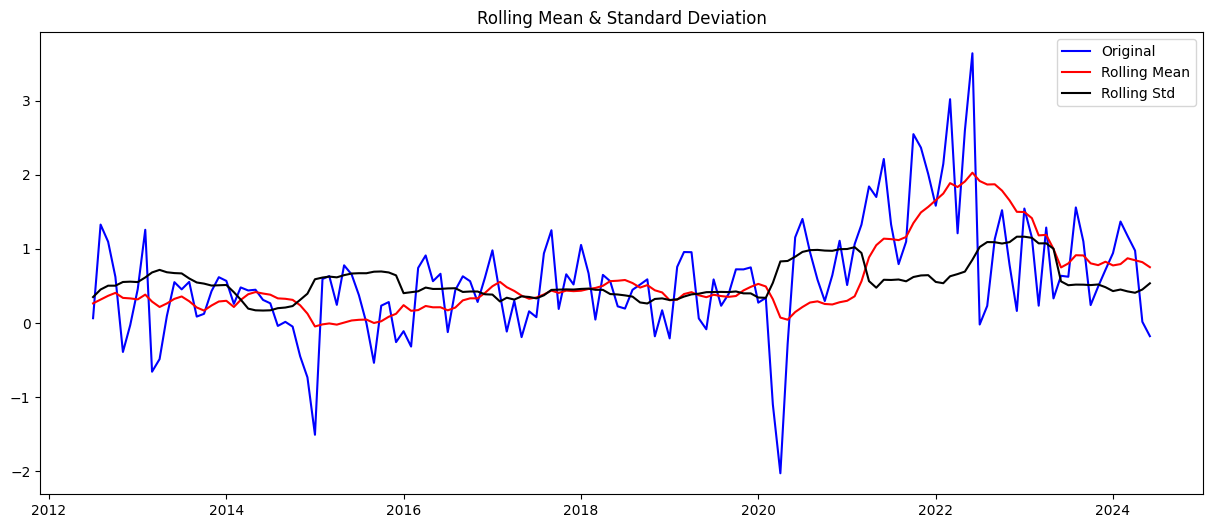

In [69]:
#12 month window
rolling_mean = df['value_diff'].rolling(window=12).mean()
rolling_std = df['value_diff'].rolling(window=12).std()

#12 years
df2 = df.tail(144)
rolling_mean = rolling_mean.tail(144)
rolling_std = rolling_std.tail(144)

#graph rolling mean and std. deviation
plt.figure(figsize=(15, 6))
plt.plot(df2['value_diff'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

To quantitatively test for stationarity, I deploy an Augmented Dickey-Fuller (ADF) test.

In [63]:
#check stationarity
adf_test = adfuller(df['value_diff'], autolag='AIC')
adf_results = pd.Series(adf_test[0:4], index=['ADF Statistic', 'P-value', 'Lags', 'Observations'])
for key, value in adf_test[4].items():
    adf_results[f'Critical Value at {key} level'] = value
print(adf_results)


ADF Statistic                   -3.846274
P-value                          0.002468
Lags                            14.000000
Observations                   903.000000
Critical Value at 1% level      -3.437612
Critical Value at 5% level      -2.864746
Critical Value at 10% level     -2.568477
dtype: float64


The results of the ADF test show the data is stationary. The ACF and PACF plots are used to determine the number of auto regressive terms (p) and moving average terms (q) to include in the model.

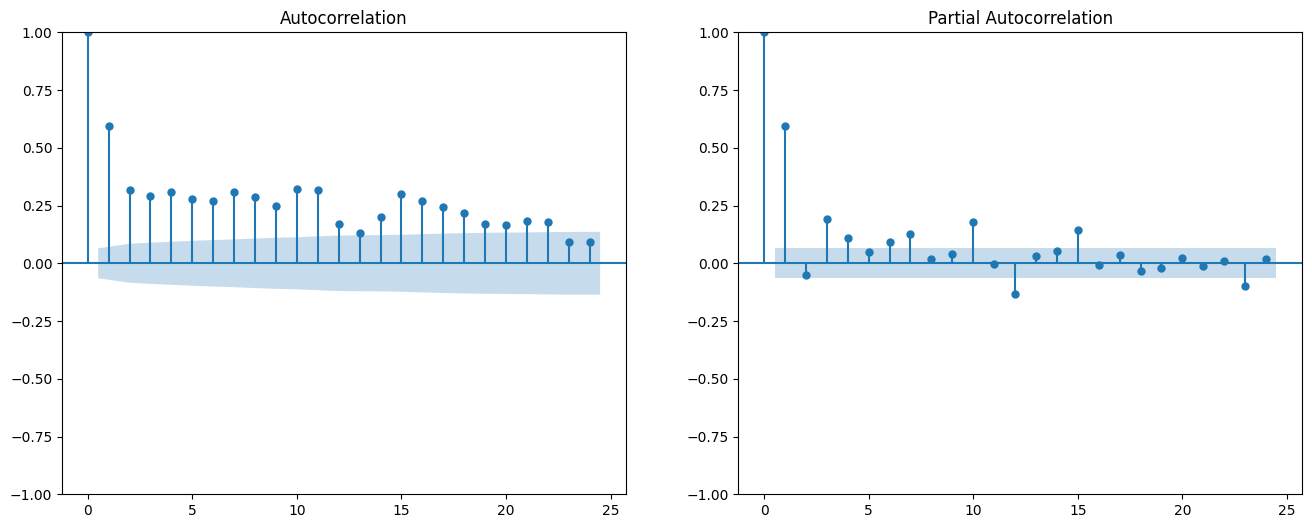

C:\Users\Cole Jones\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Cole Jones\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Cole Jones\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  918
Model:                ARIMA(12, 1, 1)   Log Likelihood                -367.939
Date:                Tue, 06 Aug 2024   AIC                            763.878
Time:                        09:36:02   BIC                            831.374
Sample:                    01-01-1948   HQIC                           789.639
                         - 06-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0173      0.137     -0.126      0.900      -0.286       0.251
ar.L2          0.2190      0.077      2.855      0.004       0.069       0.369
ar.L3         -0.0145      0.030     -0.483      0.6

In [129]:
#ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sm.graphics.tsa.plot_acf(df['value_diff'], lags=24, ax=axes[0])
sm.graphics.tsa.plot_pacf(df['value_diff'], lags=24, ax=axes[1])
plt.show()

#ARIMA model
model = ARIMA(df['value'], order=(12, 1, 1))
results = model.fit()

print(results.summary())


The first-order differencing (d=1) is applied to the data and the model integrates the differenced forecasts back into the original scale. The result of the ARIMA model is satisfactory. An AIC (Akaike Information Criterion) value of 763.878 concluded to be the lowest AIC value.

C:\Users\Cole Jones\AppData\Local\Temp\ipykernel_3536\1395055988.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=24, freq='M')


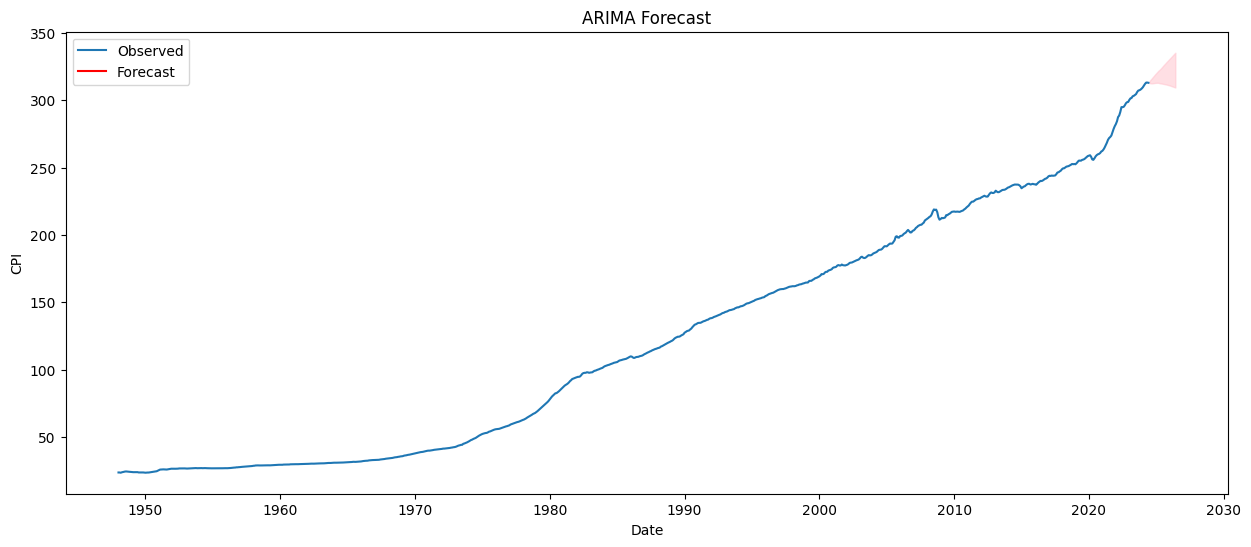

In [102]:
#visualize the forecast
forecast = results.get_forecast(steps=24)
forecast_index = pd.date_range(start=df.index[-1], periods=24, freq='M')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

plt.figure(figsize=(15, 6))
plt.plot(df['value'], label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.5)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

C:\Users\Cole Jones\AppData\Local\Temp\ipykernel_3536\3789091718.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1], periods=24, freq='M')


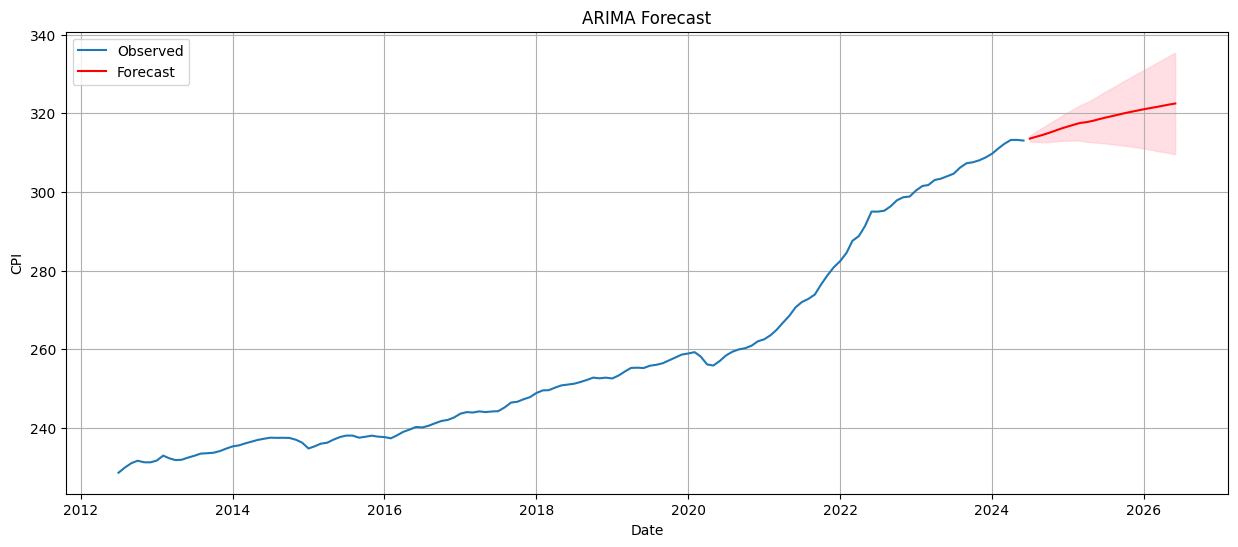

In [132]:
#visualize 10 years of historical data and the forecast
forecast = results.get_forecast(steps=24)
forecast_index = pd.date_range(start=df.index[-1], periods=24, freq='M')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

#confidence intervals and means of forecasts
conf_int = forecast.conf_int()
forecast_series = forecast.predicted_mean

#12 years
df2 = df.tail(144)

plt.figure(figsize=(15, 6))
plt.plot(df2['value'], label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.5)
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.grid()
plt.legend()
plt.show()

In [127]:
#final df
forecast_df = pd.DataFrame({
    'Actuals': df['value'],
    'Forecast': forecast_series,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
})

print(forecast_df.tail(30))

            Actuals    Forecast    Lower CI    Upper CI
2024-01-01  309.685         NaN         NaN         NaN
2024-02-01  311.054         NaN         NaN         NaN
2024-03-01  312.230         NaN         NaN         NaN
2024-04-01  313.207         NaN         NaN         NaN
2024-05-01  313.225         NaN         NaN         NaN
2024-06-01  313.049         NaN         NaN         NaN
2024-07-01      NaN  313.552150  312.844526  314.259774
2024-08-01      NaN  314.025610  312.689118  315.362102
2024-09-01      NaN  314.485654  312.634108  316.337201
2024-10-01      NaN  315.001765  312.703284  317.300246
2024-11-01      NaN  315.568713  312.832364  318.305063
2024-12-01      NaN  316.138994  312.963748  319.314239
2025-01-01      NaN  316.637370  313.035585  320.239155
2025-02-01      NaN  317.126694  313.082372  321.171015
2025-03-01      NaN  317.537088  313.021124  322.053052
2025-04-01      NaN  317.742125  312.758167  322.726083
2025-05-01      NaN  318.077585  312.598040  323